In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans

import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import re

In [23]:
game_ids = pd.DataFrame()

years = [2024]  

for year in years:
    url = f'https://understat.com/league/EPL/{year}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'lxml')
    
    script = soup.find('script', text=lambda t: "JSON.parse" in t)
    if script:
        #extraindo o JSON dentro do script
        json_str = script.string
        start_idx = json_str.index("('") + 2
        end_idx = json_str.index("')")
        json_data = json_str[start_idx:end_idx]
        
        #decodificando caracteres especiais e carregando o JSON
        json_data = json_data.encode('utf8').decode('unicode_escape')
        data = json.loads(json_data)
        
        #convertendo para DataFrame e ordenando por datetime
        df = pd.DataFrame(data).sort_values('datetime')
        
        # Concatenando com os dados existentes
        game_ids = pd.concat([game_ids, df], ignore_index=True)

#convertendo a coluna 'id' para int32
game_ids['id'] = game_ids['id'].astype('int32')

#obtendo a lista de IDs
game_ids_list = game_ids['id'].tolist()

print(len(game_ids_list))


380


/tmp/ipykernel_129734/3587973113.py:10: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', text=lambda t: "JSON.parse" in t)


In [24]:
link = "https://understat.com/league/EPL"

#obtendo o conteúdo da página
res = requests.get(link)
soup = BeautifulSoup(res.content, 'lxml')

#encontrando todos os scripts na página
scripts = soup.find_all('script')

#procurando pelo script correto que contém os dados desejados (geralmente o quarto script)
for script in scripts:
    if "playersData" in str(script):
        #encontrando o índice de início e fim do JSON
        start_idx = script.string.index("('") + 2
        end_idx = script.string.index("')")
        
        #extraindo e decodificando os dados JSON
        json_data = script.string[start_idx:end_idx].encode('utf8').decode('unicode_escape')
        
        #carregando os dados JSON em um DataFrame do Pandas
        players = pd.DataFrame(json.loads(json_data))
        break  #parar após encontrar o script correto

#exibindo o DataFrame com os dados dos jogadores
print(players)


        id      player_name games  time goals                   xG assists  \
0     8260   Erling Haaland    31  2581    27    31.65399668365717       5   
1     8497      Cole Palmer    34  2640    22    17.83224501274526      11   
2     5232   Alexander Isak    30  2305    21    22.07426631450653       2   
3     1679  Dominic Solanke    38  3346    19    21.40683087334037       3   
4     6055       Phil Foden    35  2895    19   11.307983005419374       8   
..     ...              ...   ...   ...   ...                  ...     ...   
565  12535  Josh Acheampong     1     1     0                    0       0   
566  12549   Fred Onyedinma     8   419     0  0.18410924077033997       0   
567  12568   Ethan Wheatley     3     9     0                    0       0   
568  12581    Finley Munroe     1     1     0                    0       0   
569  12603      Mikey Moore     2     2     0                    0       0   

                      xA shots key_passes yellow_cards red_card

In [25]:
players.columns

Index(['id', 'player_name', 'games', 'time', 'goals', 'xG', 'assists', 'xA',
       'shots', 'key_passes', 'yellow_cards', 'red_cards', 'position',
       'team_title', 'npg', 'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

In [27]:
match_stats = pd.DataFrame()

for i in tqdm(game_ids_list):
    try:
        response = requests.get(f'https://understat.com/match/{i}')
        response.raise_for_status()  
        match_info = re.search(r"match_info\s+=\s+JSON.parse\('([^']+)", response.text)
        if match_info:
            decoded_string = bytes(match_info.groups()[0], 'utf-8').decode('unicode_escape')
            matchObj = json.loads(decoded_string)
            sh = pd.Series(matchObj)
            match_stats = pd.concat([match_stats, pd.DataFrame(sh).T], ignore_index=True)
        else:
            print(f"Não foi possível encontrar informações para o jogo {i}")
    except requests.exceptions.RequestException as e:
        print(f"Erro ao tentar obter o jogo {i}: {e}")
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar JSON para o jogo {i}: {e}")

print(match_stats)  


100%|██████████| 380/380 [05:37<00:00,  1.13it/s]

        id      fid    h    a                 date league_id season h_goals  \
0    22275  1729191   92   88  2023-08-11 19:00:00         1   2023       0   
1    22276  1729190   83  249  2023-08-12 11:30:00         1   2023       2   
2    22277  1729192   73   81  2023-08-12 14:00:00         1   2023       1   
3    22278  1729193  220  256  2023-08-12 14:00:00         1   2023       4   
4    22279  1729194   72  228  2023-08-12 14:00:00         1   2023       0   
5    22280  1729195  238   78  2023-08-12 14:00:00         1   2023       0   
6    22281  1729196   86   71  2023-08-12 16:30:00         1   2023       5   
7    22282  1729197  244   82  2023-08-13 13:00:00         1   2023       2   
8    22283  1729198   80   87  2023-08-13 15:30:00         1   2023       1   
9    22284  1729199   89  229  2023-08-14 19:00:00         1   2023       1   
10   22285  1729249  249  238  2023-08-18 18:45:00         1   2023       2   
11   22286  1729254  229  220  2023-08-19 14:00:00  

In [28]:
print(match_stats.columns)

Index(['id', 'fid', 'h', 'a', 'date', 'league_id', 'season', 'h_goals',
       'a_goals', 'team_h', 'team_a', 'h_xg', 'a_xg', 'h_w', 'h_d', 'h_l',
       'league', 'h_shot', 'a_shot', 'h_shotOnTarget', 'a_shotOnTarget',
       'h_deep', 'a_deep', 'a_ppda', 'h_ppda'],
      dtype='object')


In [29]:
all_teams = pd.concat([match_stats['team_h'], match_stats['team_a']]).unique()

for team in all_teams:
    print(team)

Burnley
Arsenal
Bournemouth
Brighton
Everton
Sheffield United
Newcastle United
Brentford
Chelsea
Manchester United
Nottingham Forest
Wolverhampton Wanderers
Fulham
Liverpool
Tottenham
Manchester City
Aston Villa
West Ham
Crystal Palace
Luton


In [30]:
columns = ['team', 'played', 'won', 'drawn', 'lost', 'goals_for', 'goals_against', 'goal_difference', 'points']
league_table = pd.DataFrame(columns=columns)

def update_table(row, league_table):
    update_team_stats(row['team_h'], int(row['h_goals']), int(row['a_goals']), league_table)
    update_team_stats(row['team_a'], int(row['a_goals']), int(row['h_goals']), league_table)

def update_team_stats(team, goals_for, goals_against, league_table):
    if team not in league_table['team'].values:
        league_table.loc[len(league_table)] = [team, 0, 0, 0, 0, 0, 0, 0, 0]

    idx = league_table.index[league_table['team'] == team][0]
    league_table.at[idx, 'played'] += 1
    league_table.at[idx, 'goals_for'] += goals_for
    league_table.at[idx, 'goals_against'] += goals_against
    league_table.at[idx, 'goal_difference'] = (league_table.at[idx, 'goals_for'] 
                                               - league_table.at[idx, 'goals_against'])

    if goals_for > goals_against:
        league_table.at[idx, 'won'] += 1
        league_table.at[idx, 'points'] += 3
    elif goals_for < goals_against:
        league_table.at[idx, 'lost'] += 1
    else:
        league_table.at[idx, 'drawn'] += 1
        league_table.at[idx, 'points'] += 1

for index, row in match_stats.iterrows():
    update_table(row, league_table)

league_table = league_table.sort_values(by=['points', 'goal_difference'], ascending=False).reset_index(drop=True)

league_table = pd.DataFrame(league_table)
league_table


,team,played,won,drawn,lost,goals_for,goals_against,goal_difference,points
0,Manchester City,38,28,7,3,96,34,62,91
1,Arsenal,38,28,5,5,91,29,62,89
2,Liverpool,38,24,10,4,86,41,45,82
3,Aston Villa,38,20,8,10,76,61,15,68
4,Tottenham,38,20,6,12,74,61,13,66
5,Chelsea,38,18,9,11,77,63,14,63
6,Newcastle United,38,18,6,14,85,62,23,60
7,Manchester United,38,18,6,14,57,58,-1,60
8,West Ham,38,14,10,14,60,74,-14,52
9,Crystal Palace,38,13,10,15,57,58,-1,49


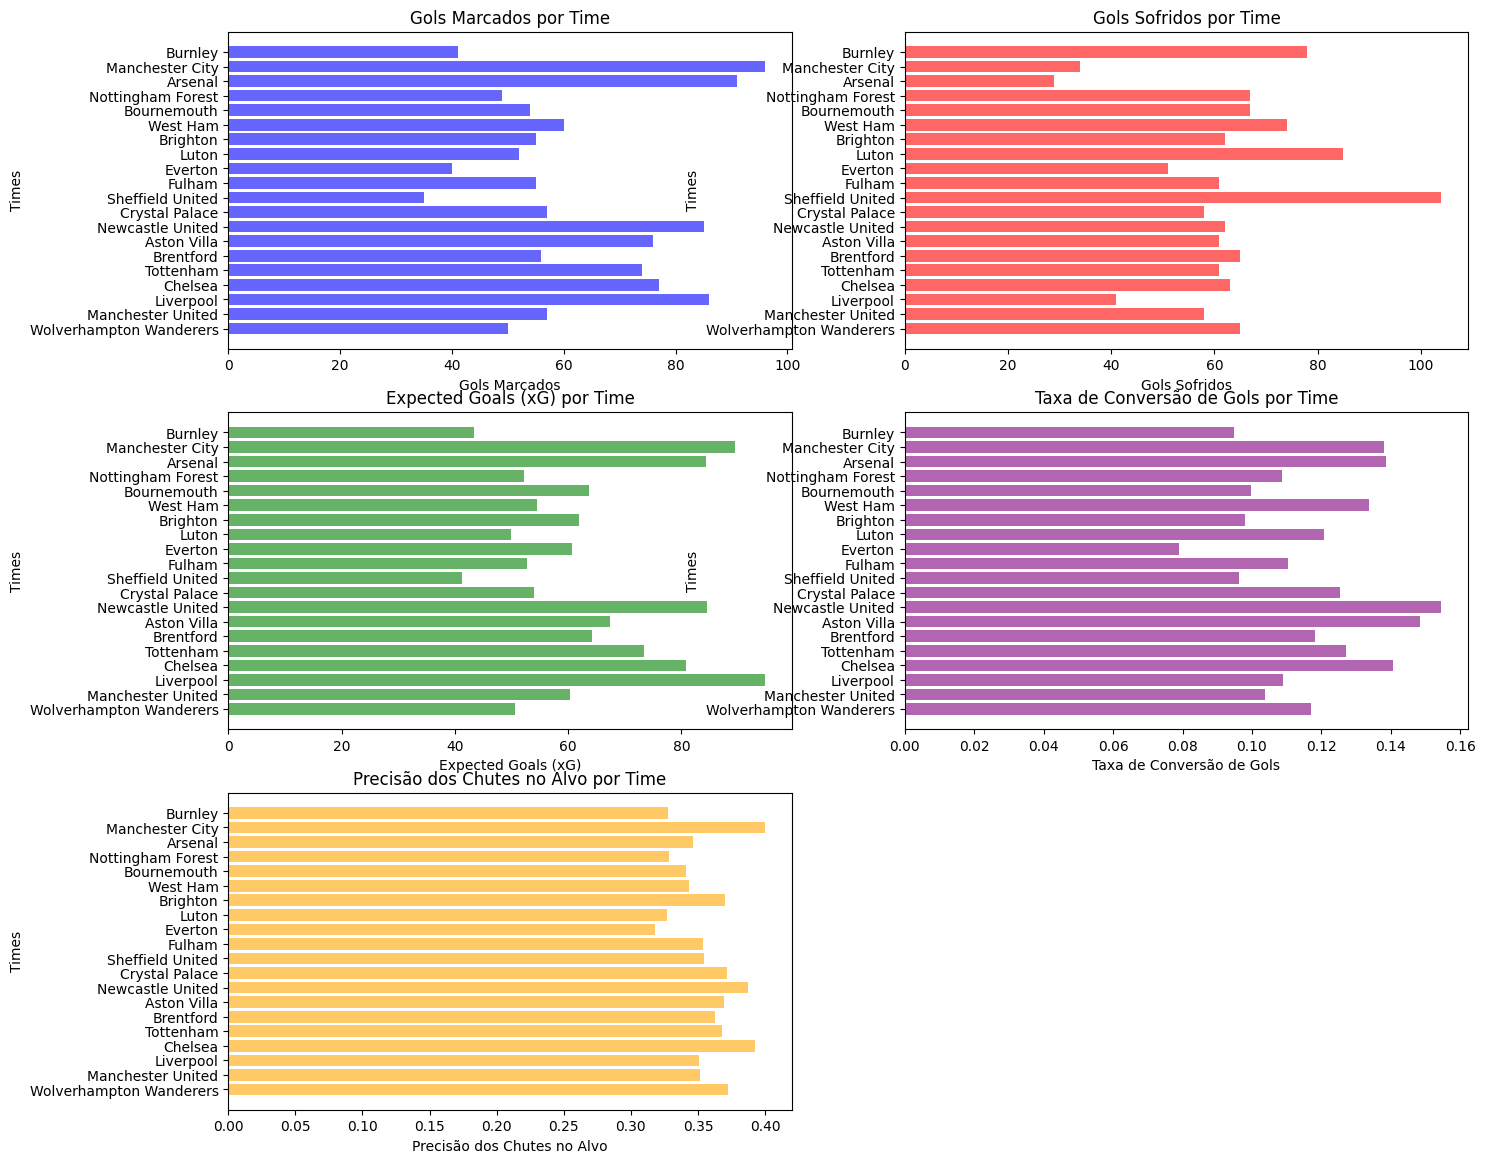

In [31]:
def calculate_goal_conversion(goals, shots):
    return (goals / shots) if shots > 0 else 0.0

def calculate_shot_accuracy(shots_on_target, shots):
    return (shots_on_target / shots) if shots > 0 else 0.0

teams_stats = {}

for index, row in match_stats.iterrows():
    try:
        h_goals = int(row['h_goals'])
        h_xg = float(row['h_xg'])
        h_shot = int(row['h_shot'])
        h_shotOnTarget = int(row['h_shotOnTarget'])
        
        if isinstance(row['h_ppda'], dict) and 'att' in row['h_ppda'] and 'def' in row['h_ppda']:
            h_ppda = {
                'att': int(row['h_ppda']['att']),
                'def': int(row['h_ppda']['def'])
            }
        else:
            h_ppda = {'att': 0, 'def': 0} 
        
        a_goals = int(row['a_goals'])
        a_xg = float(row['a_xg'])
        a_shot = int(row['a_shot'])
        a_shotOnTarget = int(row['a_shotOnTarget'])
        
        if isinstance(row['a_ppda'], dict) and 'att' in row['a_ppda'] and 'def' in row['a_ppda']:
            a_ppda = {
                'att': int(row['a_ppda']['att']),
                'def': int(row['a_ppda']['def'])
            }
        else:
            a_ppda = {'att': 0, 'def': 0}  

        if row['team_h'] not in teams_stats:
            teams_stats[row['team_h']] = {
                'goals_scored': h_goals,
                'goals_conceded': a_goals,
                'xG': h_xg,
                'shots': h_shot,
                'shots_on_target': h_shotOnTarget,
                'ppda_att': h_ppda['att'],
                'ppda_def': h_ppda['def'],
                'matches_played': 1
            }
        else:
            teams_stats[row['team_h']]['goals_scored'] += h_goals
            teams_stats[row['team_h']]['goals_conceded'] += a_goals
            teams_stats[row['team_h']]['xG'] += h_xg
            teams_stats[row['team_h']]['shots'] += h_shot
            teams_stats[row['team_h']]['shots_on_target'] += h_shotOnTarget
            teams_stats[row['team_h']]['ppda_att'] += h_ppda['att']
            teams_stats[row['team_h']]['ppda_def'] += h_ppda['def']
            teams_stats[row['team_h']]['matches_played'] += 1
        
        if row['team_a'] not in teams_stats:
            teams_stats[row['team_a']] = {
                'goals_scored': a_goals,
                'goals_conceded': h_goals,
                'xG': a_xg,
                'shots': a_shot,
                'shots_on_target': a_shotOnTarget,
                'ppda_att': a_ppda['att'],
                'ppda_def': a_ppda['def'],
                'matches_played': 1
            }
        else:
            teams_stats[row['team_a']]['goals_scored'] += a_goals
            teams_stats[row['team_a']]['goals_conceded'] += h_goals
            teams_stats[row['team_a']]['xG'] += a_xg
            teams_stats[row['team_a']]['shots'] += a_shot
            teams_stats[row['team_a']]['shots_on_target'] += a_shotOnTarget
            teams_stats[row['team_a']]['ppda_att'] += a_ppda['att']
            teams_stats[row['team_a']]['ppda_def'] += a_ppda['def']
            teams_stats[row['team_a']]['matches_played'] += 1

    except ValueError as e:
        print(f"Erro ao processar jogo {index}: {e}")
        continue

teams_analysis = []

for team, stats in teams_stats.items():
    metrics = {
        'goals_scored': stats['goals_scored'],
        'goals_conceded': stats['goals_conceded'],
        'xG': stats['xG'],
        'shots': stats['shots'],
        'shots_on_target': stats['shots_on_target'],
        'goal_conversion_rate': calculate_goal_conversion(stats['goals_scored'], stats['shots']),
        'shot_accuracy': calculate_shot_accuracy(stats['shots_on_target'], stats['shots']),
        'avg_ppda_att': stats['ppda_att'] / stats['matches_played'],
        'avg_ppda_def': stats['ppda_def'] / stats['matches_played']
    }
    teams_analysis.append({
        'team': team,
        'metrics': metrics
    })

plt.figure(figsize=(16, 14))

plt.subplot(3, 2, 1)
plt.barh([team['team'] for team in teams_analysis], [team['metrics']['goals_scored'] for team in teams_analysis], color='b', alpha=0.6)
plt.xlabel('Gols Marcados')
plt.ylabel('Times')
plt.title('Gols Marcados por Time')
plt.gca().invert_yaxis()  

plt.subplot(3, 2, 2)
plt.barh([team['team'] for team in teams_analysis], [team['metrics']['goals_conceded'] for team in teams_analysis], color='r', alpha=0.6)
plt.xlabel('Gols Sofridos')
plt.ylabel('Times')
plt.title('Gols Sofridos por Time')
plt.gca().invert_yaxis()  

plt.subplot(3, 2, 3)
plt.barh([team['team'] for team in teams_analysis], [team['metrics']['xG'] for team in teams_analysis], color='g', alpha=0.6)
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Times')
plt.title('Expected Goals (xG) por Time')
plt.gca().invert_yaxis()  

plt.subplot(3, 2, 4)
plt.barh([team['team'] for team in teams_analysis], [team['metrics']['goal_conversion_rate'] for team in teams_analysis], color='purple', alpha=0.6)
plt.xlabel('Taxa de Conversão de Gols')
plt.ylabel('Times')
plt.title('Taxa de Conversão de Gols por Time')
plt.gca().invert_yaxis()  

plt.subplot(3, 2, 5)
plt.barh([team['team'] for team in teams_analysis], [team['metrics']['shot_accuracy'] for team in teams_analysis], color='orange', alpha=0.6)
plt.xlabel('Precisão dos Chutes no Alvo')
plt.ylabel('Times')
plt.title('Precisão dos Chutes no Alvo por Time')
plt.gca().invert_yaxis() 

In [32]:
def calculate_performance_stats(team, matches):
    home_matches = matches[matches['team_h'] == team]
    away_matches = matches[matches['team_a'] == team]

    home_stats = {
        'avg_goals_for': home_matches['h_goals'].astype(int).mean(),
        'avg_goals_against': home_matches['a_goals'].astype(int).mean(),
        'win_rate': (home_matches['h_goals'].astype(int) > home_matches['a_goals'].astype(int)).mean() * 100,
        'draw_rate': (home_matches['h_goals'].astype(int) == home_matches['a_goals'].astype(int)).mean() * 100,
        'lose_rate': (home_matches['h_goals'].astype(int) < home_matches['a_goals'].astype(int)).mean() * 100
    }

    away_stats = {
        'avg_goals_for': away_matches['a_goals'].astype(int).mean(),
        'avg_goals_against': away_matches['h_goals'].astype(int).mean(),
        'win_rate': (away_matches['a_goals'].astype(int) > away_matches['h_goals'].astype(int)).mean() * 100,
        'draw_rate': (away_matches['a_goals'].astype(int) == away_matches['h_goals'].astype(int)).mean() * 100,
        'lose_rate': (away_matches['a_goals'].astype(int) < away_matches['h_goals'].astype(int)).mean() * 100
    }

    return home_stats, away_stats

team_performance_data = []

for team in all_teams:
    home_stats, away_stats = calculate_performance_stats(team, match_stats)
    team_performance_data.append({
        'Team': team,
        'Home Goals For': home_stats['avg_goals_for'],
        'Home Goals Against': home_stats['avg_goals_against'],
        'Home Win Rate (%)': home_stats['win_rate'],
        'Home Draw Rate (%)': home_stats['draw_rate'],
        'Home Lose Rate (%)': home_stats['lose_rate'],
        'Away Goals For': away_stats['avg_goals_for'],
        'Away Goals Against': away_stats['avg_goals_against'],
        'Away Win Rate (%)': away_stats['win_rate'],
        'Away Draw Rate (%)': away_stats['draw_rate'],
        'Away Lose Rate (%)': away_stats['lose_rate']
    })

team_performance_df = pd.DataFrame(team_performance_data)

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 200)  

def format_df_with_lines(df):
    formatted_df = df.copy()
    return formatted_df

formatted_df = format_df_with_lines(team_performance_df)

teams_stats = pd.DataFrame(formatted_df)
teams_stats


,Team,Home Goals For,Home Goals Against,Home Win Rate (%),Home Draw Rate (%),Home Lose Rate (%),Away Goals For,Away Goals Against,Away Win Rate (%),Away Draw Rate (%),Away Lose Rate (%)
0,Burnley,1.000000,2.263158,10.526316,21.052632,68.421053,1.157895,1.842105,15.789474,26.315789,57.894737
1,Arsenal,2.526316,0.842105,78.947368,10.526316,10.526316,2.263158,0.684211,68.421053,15.789474,15.789474
2,Bournemouth,1.421053,1.473684,36.842105,31.578947,31.578947,1.421053,2.052632,31.578947,15.789474,52.631579
3,Brighton,1.578947,1.421053,42.105263,31.578947,26.315789,1.315789,1.842105,21.052632,31.578947,47.368421
4,Everton,1.157895,0.947368,42.105263,21.052632,36.842105,0.947368,1.736842,26.315789,26.315789,47.368421
5,Sheffield United,1.000000,3.000000,10.526316,21.052632,68.421053,0.842105,2.473684,5.263158,15.789474,78.947368
6,Newcastle United,2.578947,1.157895,63.157895,21.052632,15.789474,1.894737,2.105263,31.578947,10.526316,57.894737
7,Brentford,1.526316,1.789474,26.315789,36.842105,36.842105,1.421053,1.631579,26.315789,10.526316,63.157895
8,Chelsea,2.315789,1.368421,57.894737,21.052632,21.052632,1.736842,1.947368,36.842105,26.315789,36.842105
9,Manchester United,1.631579,1.473684,52.631579,15.789474,31.578947,1.368421,1.578947,42.105263,15.789474,42.105263


In [33]:
match_stats['h_ppda'] = pd.to_numeric(match_stats['h_ppda'], errors='coerce')
match_stats['a_ppda'] = pd.to_numeric(match_stats['a_ppda'], errors='coerce')

avg_ppda_home = match_stats.groupby('team_h')['h_ppda'].mean().reset_index()
avg_ppda_home.rename(columns={'team_h': 'Team', 'h_ppda': 'Average Home PPDA'}, inplace=True)

avg_ppda_away = match_stats.groupby('team_a')['a_ppda'].mean().reset_index()
avg_ppda_away.rename(columns={'team_a': 'Team', 'a_ppda': 'Average Away PPDA'}, inplace=True)

avg_ppda_table = pd.merge(avg_ppda_home, avg_ppda_away, on='Team', how='outer')

print("Tabela de Médias de PPDA por Time:")

avg_ppda_table = pd.DataFrame(avg_ppda_table)
avg_ppda_table

Tabela de Médias de PPDA por Time:


,Team,Average Home PPDA,Average Away PPDA
0,Arsenal,9.953211,9.561068
1,Aston Villa,13.420884,18.010095
2,Bournemouth,9.940163,10.790716
3,Brentford,10.850989,11.135847
4,Brighton,10.680084,10.631800
5,Burnley,13.634663,14.934400
6,Chelsea,11.340695,9.738074
7,Crystal Palace,13.677068,16.429411
8,Everton,14.087774,16.015316
9,Fulham,15.853653,15.430005


In [34]:
#convertendo colunas relevantes para valores numéricos
players[['goals', 'xG', 'assists', 'xA', 'games', 'time', 'shots', 'key_passes', 'yellow_cards', 'red_cards', 'npg', 'npxG', 'xGChain', 'xGBuildup']] = players[['goals', 'xG', 'assists', 'xA', 'games', 'time', 'shots', 'key_passes', 'yellow_cards', 'red_cards', 'npg', 'npxG', 'xGChain', 'xGBuildup']].apply(pd.to_numeric)

#ordenar os jogadores com base no número de gols marcados
top_scorers = players.sort_values(by='goals', ascending=False)

#exibir os 10 jogadores com mais gols
print("Top 10 Jogadores com Mais Gols:")
top_scorers_pd = pd.DataFrame(top_scorers.head(10))
top_scorers_pd


Top 10 Jogadores com Mais Gols:


,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,8260,Erling Haaland,31,2581,27,31.653997,5,4.751756,122,29,1,0,F S,Manchester City,20,25.564646,30.197254,3.128645
1,8497,Cole Palmer,34,2640,22,17.832245,11,11.869294,108,72,7,0,F M S,"Chelsea,Manchester City",13,10.981725,31.036520,15.302413
2,5232,Alexander Isak,30,2305,21,22.074266,2,3.652040,78,27,1,0,F S,Newcastle United,16,17.507253,24.041152,5.754798
4,6055,Phil Foden,35,2895,19,11.307983,8,8.516233,105,73,2,0,F M S,Manchester City,19,11.307983,30.416967,16.998998
3,1679,Dominic Solanke,38,3346,19,21.406831,3,3.543750,109,39,3,0,F S,Bournemouth,17,19.123324,22.588012,4.080138
5,8865,Ollie Watkins,37,3250,19,19.264598,13,7.745745,106,45,4,0,F,Aston Villa,19,19.264598,29.229418,5.899642
6,1250,Mohamed Salah,32,2556,18,21.941274,10,12.332044,114,66,2,0,F S,Liverpool,13,16.613167,31.875096,8.363567
7,453,Son Heung-Min,35,2989,17,12.978621,10,13.341021,85,69,1,0,F M S,Tottenham,15,11.456283,30.115575,10.445971
10,7322,Bukayo Saka,35,2990,16,16.807056,8,11.325986,107,89,4,0,F,Arsenal,10,12.240043,30.357597,13.228620
9,5735,Jean-Philippe Mateta,35,2303,16,12.290524,5,3.527063,46,32,3,0,F S,Crystal Palace,14,10.768186,15.486321,2.852151


In [35]:
from sklearn.preprocessing import StandardScaler
features = players[['goals', 'xG', 'assists', 'xA', 'shots', 'key_passes']]

kmeans = KMeans(n_clusters=4, random_state=42)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

players['cluster'] = clusters
cluster_stats = players.groupby('cluster').agg({
    'goals': ['mean', 'std', 'min', 'max'],
    'assists': ['mean', 'std', 'min', 'max']
})

print("Estatísticas por Cluster:")
print(pd.DataFrame(cluster_stats))
print()

Estatísticas por Cluster:
             goals                     assists                  
              mean       std min max      mean       std min max
cluster                                                         
0         4.727273  2.582262   0  10  6.818182  2.223267   2  10
1         0.455959  0.775855   0   5  0.409326  0.744375   0   3
2        14.583333  4.959985   7  27  6.541667  2.918891   2  13
3         3.982759  2.895222   0  14  2.086207  1.374102   0   6



In [36]:
for cluster_num in range(4):
    print(f"Cluster {cluster_num}:")
    cluster_players = players[players['cluster'] == cluster_num]
    for index, player in cluster_players.iterrows():
        print(f"Player: {player['player_name']}, Team: {player['team_title']}")
    print()

Cluster 0:
Player: Leon Bailey, Team: Aston Villa
Player: Michael Olise, Team: Crystal Palace
Player: Douglas Luiz, Team: Aston Villa
Player: Bryan Mbeumo, Team: Brentford
Player: Rodri, Team: Manchester City
Player: Martin Odegaard, Team: Arsenal
Player: Dejan Kulusevski, Team: Tottenham
Player: Mohammed Kudus, Team: West Ham
Player: James Ward-Prowse, Team: West Ham
Player: Declan Rice, Team: Arsenal
Player: Bruno Guimarães, Team: Newcastle United
Player: Bernardo Silva, Team: Manchester City
Player: Moussa Diaby, Team: Aston Villa
Player: John McGinn, Team: Aston Villa
Player: Gabriel Martinelli, Team: Arsenal
Player: Ross Barkley, Team: Luton
Player: Morgan Gibbs-White, Team: Nottingham Forest
Player: Alexis Mac Allister, Team: Liverpool
Player: Conor Gallagher, Team: Chelsea
Player: Anthony Elanga, Team: Nottingham Forest
Player: Brennan Johnson, Team: Nottingham Forest,Tottenham
Player: Pascal Groß, Team: Brighton
Player: Kevin De Bruyne, Team: Manchester City
Player: Jordan Ayew

In [38]:
cluster_team_counts = players.groupby(['cluster', 'team_title']).size().reset_index(name='count')

print("Contagem de times em cada cluster:")
print(cluster_team_counts)

Contagem de times em cada cluster:
    cluster                               team_title  count
0         0                                  Arsenal      3
1         0                              Aston Villa      4
2         0                              Bournemouth      2
3         0                                Brentford      1
4         0                                 Brighton      1
5         0                                  Chelsea      2
6         0                           Crystal Palace      2
7         0                                  Everton      1
8         0                                   Fulham      1
9         0                                Liverpool      5
10        0                                    Luton      2
11        0                          Manchester City      4
12        0                         Newcastle United      3
13        0                        Nottingham Forest      2
14        0              Nottingham Forest,Tottenham      1
15   

In [39]:
cluster_team_counts_sorted = cluster_team_counts.sort_values(by=['cluster', 'count'], ascending=[True, False])

print("Times que mais aparecem em cada cluster:")
for cluster_num in range(4):
    print(f"Cluster {cluster_num}:")
    top_teams = cluster_team_counts_sorted[cluster_team_counts_sorted['cluster'] == cluster_num].head()['team_title'].tolist()
    print(top_teams)
    print()

Times que mais aparecem em cada cluster:
Cluster 0:
['Liverpool', 'Aston Villa', 'Manchester City', 'West Ham', 'Arsenal']

Cluster 1:
['Sheffield United', 'Nottingham Forest', 'Aston Villa', 'Chelsea', 'Brighton']

Cluster 2:
['Liverpool', 'Manchester City', 'Arsenal', 'Crystal Palace', 'Manchester United']

Cluster 3:
['Burnley', 'Bournemouth', 'Everton', 'Fulham', 'Brighton']

